## Mean-Variance Approach
---

The minimum variance portfolio problem is formulated as follows.

$$
\begin{split}
 \min_{w}\quad & \sigma_P^2=w^{\intercal}\Sigma w, \\
 \text{subject to}\quad
 & \text{(a)}\ w^{\intercal}\mu = \mu_P, \\
 & \text{(b)}\ w^{\intercal}\iota = 1, \\
 & \text{(c)}\ w\geqq 0,
\end{split}
$$

where

$$
 w = \begin{bmatrix} w_1 \\ \vdots \\ w_N \end{bmatrix}, \quad 
 \mu = \begin{bmatrix} \mu_1 \\ \vdots \\ \mu_N \end{bmatrix}, \quad 
 \Sigma = \begin{bmatrix} \sigma_1^2 & \cdots & \sigma_{1N} \\
 \vdots & \ddots & \vdots \\
 \sigma_{N1} & \cdots & \sigma_N^2 \\
 \end{bmatrix}.
$$

+ $\mu$ - mean vector
+ $\Sigma$ - covariance matrix
+ $\iota$ - vector whose elements are all equal to one

## Minimum Variance Frontier with Short Selling
---


In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

In the following cell, the mean vector `Mean`, the covariance matrix `Sigma` are defined. Note that
`Stdev` is a vector of standard deviations and `diag` create a diagonal matrix from a vector. So

```Python
Sigma = np.diag(Stdev) @ CorrMatrix @ np.diag(Stdev)
```

creates the covariance matrix `Sigma` we need. `@` is the operator for matrix multiplication.

`iota` is a vector whose elements are all equal to one.

In [2]:
Mu = np.array([1.0, 3.0, 1.5, 6.0, 4.5])
Stdev = np.array([5.0, 10.0, 7.5, 15.0, 11.0])
CorrMatrix = np.array([[1.00, 0.25, 0.18, 0.10, 0.25],
                       [0.25, 1.00, 0.36, 0.20, 0.20],
                       [0.18, 0.36, 1.00, 0.25, 0.36],
                       [0.10, 0.20, 0.25, 1.00, 0.45],
                       [0.25, 0.20, 0.36, 0.45, 1.00]])
Sigma = np.diag(Stdev) @ CorrMatrix @ np.diag(Stdev)
iota = np.ones(Mu.shape)
np.set_printoptions(precision=3)
print(Sigma)

[[ 25.     12.5     6.75    7.5    13.75 ]
 [ 12.5   100.     27.     30.     22.   ]
 [  6.75   27.     56.25   28.125  29.7  ]
 [  7.5    30.     28.125 225.     74.25 ]
 [ 13.75   22.     29.7    74.25  121.   ]]


`inv` is a function to compute the inverse of a matrix. Note that in Python `@` is applicable as long as the length of a vector matches the length of the corresponding row/column of a matrix. So we do not need to apply the traspose operator `T` to `Mu` or `iota`.

### CVXPY - Python package for optimization problems

In [3]:
import cvxpy as cp

`CVXPY` (https://www.cvxpy.org/index.html) is a Python-embedded modeling language for optimization problems. With `CVXPY`, we can specify an optimization problem in a more accessible way. It utilizes optimization solvers to find a solution of the optimization problem.

+ `Variable()` defines variable(s) in the optimization problem
+ `Parameter()` defines parameter(s) in the optimization problem
+ `quad_form()` compute a quadratic form  $x^{\intercal}Ax$
+ `Minimize()` defines the objective function in the minimization problem
+ `Problem()` specifies the optimization problem as

```IPython
    Problem(Objective Function, [Constraints])
```

The constraints may include equality constraints (e.g., $w^{\intercal}\mu = \mu_P$) and/or inequality constraints (e.g., $w \geqq 0$).

In [4]:
Weight = cp.Variable(Mu.shape[0])
Target_Return = cp.Parameter()
Risk_Variance = cp.quad_form(Weight, Sigma)
Opt_Portfolio = cp.Problem(cp.Minimize(Risk_Variance),
                           [Weight.T*Mu == Target_Return,
                            cp.sum(Weight) == 1.0,
                            Weight >= 0.0])

`solve()` finds a solution of the optimization problem specified in the above. You need to choose a solver (`OSQP` in this example).

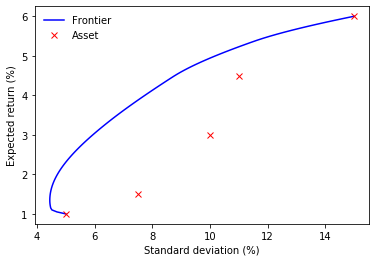

In [5]:
V_Target = np.linspace(Mu.min(), Mu.max(), num=100)
V_Risk = np.zeros(V_Target.shape)
V_Weight = np.zeros((V_Target.shape[0], Mu.shape[0]))
for idx, Target_Return.value in enumerate(V_Target):
    Opt_Portfolio.solve(solver=cp.OSQP)
    V_Weight[idx, :] = Weight.value.T
    V_Risk[idx] = np.sqrt(Risk_Variance.value)
fig1 = plt.figure(num=1, facecolor='w')
plt.plot(V_Risk, V_Target, 'b-')
plt.plot(np.sqrt(np.diagonal(Sigma)), Mu, 'rx')
plt.legend(['Frontier', 'Asset'], loc='best', frameon=False)
plt.xlabel('Standard deviation (%)')
plt.ylabel('Expected return (%)')
plt.show()

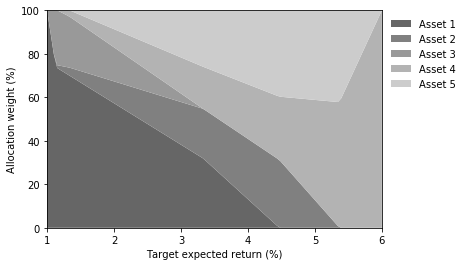

In [6]:
fig2 = plt.figure(num=2, facecolor='w')
plt.stackplot(V_Target, V_Weight.T*100,
              colors=tuple([tuple(gray*np.ones(3)) for gray in np.linspace(0.4, 0.8, num=Mu.shape[0])]))
plt.axis([Mu.min(), Mu.max(), 0.0, 100.0])
plt.legend(['Asset 1', 'Asset 2', 'Asset 3', 'Asset 4', 'Asset 5'],
           loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)
plt.xlabel('Target expected return (%)')
plt.ylabel('Allocation weight (%)')
plt.show()

## Minimum Variance Frontier with Short Selling
---

In general no closed-form solution is available for the minimum variance portfolio problem. However, if we drop (c), the solution is given by

$$
 w = 
 \frac{C\mu_P-A}{D}\Sigma^{-1}\mu + \frac{B-A\mu_P}{D}\Sigma^{-1}\iota,
$$

where

$$
 A =\mu^{\intercal}\Sigma^{-1}\iota,\ B=\mu^{\intercal}\Sigma^{-1}\mu,\ 
 C =\iota^{\intercal}\Sigma^{-1}\iota,\ D = B C - A^2.
$$

In [7]:
inv_Sigma = la.inv(Sigma)
A = Mu @ inv_Sigma @ iota
B = Mu @ inv_Sigma @ Mu
C = iota @ inv_Sigma @ iota
D = B * C - A ** 2

In [8]:
V_TR = np.linspace(Mu.min(), Mu.max(), num=5)
V_SD = np.zeros(V_TR.shape)
V_W = np.zeros((V_TR.shape[0], Mu.shape[0]))
for idx, Target_Return in enumerate(V_TR):
    V_W[idx, :] = (C * Target_Return - A) / D * la.solve(Sigma, Mu) \
                   + (B - A * Target_Return) / D * la.solve(Sigma, iota)
    V_SD[idx] = np.sqrt((C / D) * (Target_Return - A / C) ** 2 + 1.0 / C)
np.set_printoptions(precision=3)
print(np.vstack((V_TR, V_SD, V_W.T * 100)))

[[  1.      2.25    3.5     4.75    6.   ]
 [  4.518   4.935   6.781   9.236  11.929]
 [ 76.371  52.524  28.678   4.831 -19.015]
 [  0.473  12.451  24.429  36.408  48.386]
 [ 27.394  12.709  -1.976 -16.66  -31.345]
 [  0.126  10.426  20.727  31.027  41.328]
 [ -4.363  11.89   28.142  44.394  60.646]]


In [9]:
print(V_SD)

[ 4.518  4.935  6.781  9.236 11.929]


### Closed-form Expression of the Miminum Variance Frontier

Then we have the following relationship between $\mu_P$ and $\sigma_P$:

$$
 \sigma_P = \sqrt{\frac{C\mu_P^2 - 2A\mu_P + B}{D}}
 = \sqrt{\frac{C}{D}\left(\mu_P-\frac{A}{C}\right)^2+\frac1{C}}.
$$

Therefore the minimum variance frontier is given by

$$
\mu_P = \begin{cases}
\displaystyle
\frac{A + \sqrt{D(C\sigma_P^2 - 1)}}{C}, & \mu_P > \frac{A}{C}; \\
& \\
\displaystyle
\frac{A - \sqrt{D(C\sigma_P^2 - 1)}}{C}, & \mu_P < \frac{A}{C}.
\end{cases}
$$

In [10]:
sigma_gmv = 1.0 / np.sqrt(C)
sigma_p = np.linspace(sigma_gmv, 1.05 * np.max(Stdev), num=250)
mu_p_efficient = (A + np.sqrt(np.abs(C * sigma_p ** 2 - 1.0) * D)) / C
mu_p_inefficient = (A - np.sqrt(np.abs(C * sigma_p ** 2 - 1.0) * D)) / C

The upper half of the minimum variance frontier is called the <font color=red>efficient frontier</font> because the expected return is higher on the upper half than the lower half at any given level of the risk (standard deviation). In contrast to the efficient froniter, we refer to the lower half of the minimum variance frontier as the inefficient frontier, though this term is not commonly used in the field of finance.

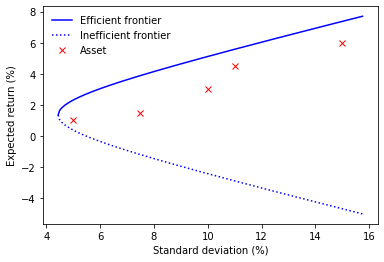

In [11]:
fig3 = plt.figure(num=3, facecolor='w')
plt.plot(sigma_p, mu_p_efficient, 'b-', label='Efficient frontier')
plt.plot(sigma_p, mu_p_inefficient, 'b:', label='Inefficient frontier')
plt.plot(np.sqrt(np.diagonal(Sigma)), Mu, 'rx', label='Asset')
plt.legend(loc='best', frameon=False)
plt.xlabel('Standard deviation (%)')
plt.ylabel('Expected return (%)')
plt.show()

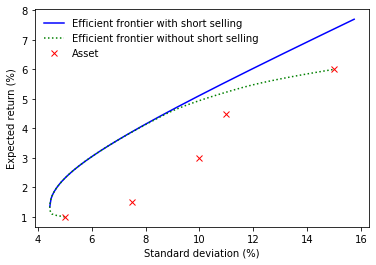

In [12]:
fig4 = plt.figure(num=4, facecolor='w')
plt.plot(sigma_p, mu_p_efficient, 'b-', label='Efficient frontier with short selling')
plt.plot(V_Risk, V_Target, 'g:', label='Efficient frontier without short selling')
plt.plot(np.sqrt(np.diagonal(Sigma)), Mu, 'rx', label='Asset')
plt.legend(loc='best',  frameon=False)
plt.xlabel('Standard deviation (%)')
plt.ylabel('Expected return (%)')
plt.show()

## Minimum Variance Portfolio with the Risk-free Asset
---

Suppose there exists an asset on which the inernal rate of return is constant under any circumstances (<font color=red>risk-free asset</font>) and let $R_f$ denote the return on the risk-free asset (<font color=red>risk-free rate</font>).

The minimum variance portfolio problem with the risk-free asset but without the short-selling constraint is formulated as

$$
\begin{split}
 \min_{w}\quad & \sigma_P^2=w^{\intercal}\Sigma w, \\
 \text{subject to}\quad & (1 - w^{\intercal}\iota)R_f + w^{\intercal}\mu = \mu_P.
\end{split}
$$

The solution of the minimum variance portfolio problem is 

$$
 w = \frac{\mu_P-R_f}{CR_f^2 - 2AR_f+B}\Sigma^{-1}(\mu_P - R_f\;\iota),
$$

where

$$
 A =\mu^{\intercal}\Sigma^{-1}\iota,\ B=\mu^{\intercal}\Sigma^{-1}\mu,\ 
 C =\iota^{\intercal}\Sigma^{-1}\iota,\ D = B C - A^2.
$$

The relationship between $\mu_P$ and $\sigma_P$ is given by

$$
 \mu_P = \begin{cases}
 R_f + \sigma_P\sqrt{CR_f^2 - 2AR_f+B}, & \mu_P > R_f; \\
 R_f - \sigma_P\sqrt{CR_f^2 - 2AR_f+B}, & \mu_P < R_f,
 \end{cases}
$$

which is also called the <font color=red>minimum variance frontier</font>.


In [13]:
R_f = 0.0
sigma_p2 = np.linspace(0, 1.2*np.sqrt(np.max(np.diagonal(Sigma))), num=250)
mu_p_riskless1 = R_f + np.sqrt(C * R_f ** 2 - 2.0 * A * R_f + B) * sigma_p2
mu_p_riskless2 = R_f - np.sqrt(C * R_f ** 2 - 2.0 * A * R_f + B) * sigma_p2

This cell creates the figure showing the minimum variance frontiers with and without the risk-free asset.

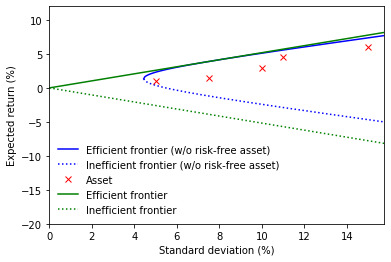

In [14]:
fig5 = plt.figure(num=5, facecolor='w')
plt.plot(sigma_p, mu_p_efficient, 'b-', label='Efficient frontier (w/o risk-free asset)')
plt.plot(sigma_p, mu_p_inefficient, 'b:', label='Inefficient frontier (w/o risk-free asset)')
plt.plot(np.sqrt(np.diagonal(Sigma)), Mu, 'rx', label='Asset')
plt.plot(sigma_p2, mu_p_riskless1, 'g-', label='Efficient frontier')
plt.plot(sigma_p2, mu_p_riskless2, 'g:', label='Inefficient frontier')
plt.legend(loc='best',  frameon=False)
plt.xlabel('Standard deviation (%)')
plt.ylabel('Expected return (%)')
plt.xlim(0, sigma_p.max())
plt.ylim(-20, 12)
plt.show()